In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from copy import deepcopy
from tqdm import tqdm
warnings.filterwarnings('ignore')
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [2]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))
cuda =torch.cuda.is_available()
print(cuda)

Current Working Directory: progettoVIPM
True


In [3]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset
from utils.fine_tune_pytorch import train_model, eval_model_on_test_loader
from utils.fine_tune_pytorch import fine_tune_network_layers, eval_model_on_test_set, train_model
from copy import deepcopy
from utils.loadersAndEnums import dataloader_stratified_kfold, separate_data_based_on_class_group
from utils.extractNeuralFeatures import extract_features, extract_features_from_dataloader
from IPython.display import clear_output

In [38]:
chosen_net = networks.FOODRESNET50
print(chosen_net.value[1])
chosen_net.value[1].fc = nn.Linear(chosen_net.value[1].fc.in_features, 101)
chosen_net.value[1].load_state_dict(torch.load("resnet50model.pth")['model_state'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
chosen_net.value[1].to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [4]:
from utils.augmentations import validation_augment

In [39]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu

linear_layers_to_remove = 1
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers, modified_net = extract_features(train_set=datasets.TRAINING_80,
                                                                                                augmented=False,
                                                                                                transform= None,
                                                                                                test_set=datasets.TEST,
                                                                                                network=chosen_net,
                                                                                                layers_to_remove=linear_layers_to_remove, 
                                                                                                cuda=cuda)
print("Original classification layers:{}".format(chosen_net.value[1].fc))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Found an existing set of features in: ./Storage/neural_features/Train_FoodResNet50_minus1_training_set_80%.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 4016
Feature vector shape of Train: (4016, 2048)
Label vector shape of Train: (4016,)
---------------------------------------------------------------------------------
Found an existing set of features in: ./Storage/neural_features/Test_FoodResNet50_minus1_val_set.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 11994
Feature vector shape of Test: (11994, 2048)
Label vector shape of Test: (11994,)
---------------------------------------------------------------------------------
Original classification layers:Linear(in_features=2048, out_features=101, bias=True)
-----------------------------------------

In [6]:
chosen_net = networks.FOODRESNET50
print(chosen_net.value[1])
chosen_net.value[1].fc = nn.Linear(chosen_net.value[1].fc.in_features, 251)
# chosen_net.value[1] = torch.load("FineTuned_ResNet50_80_Train.pth")
chosen_net.value[1].load_state_dict(torch.load("FineTuned_ResNet50_80_Train.pth"))
# chosen_net.value[1].fc = nn.Linear(chosen_net.value[1].fc.in_features, 251)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(chosen_net.value[1])

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:

model = deepcopy(chosen_net.value[1])
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

n_epochs = 10
batch_size = 64
k_for_accuracy = 5


dataset_train = ImageDataset(dataset=datasets.TRAINING_80, network_input_size=chosen_net.value[0], cuda=True, transform=validation_augment, normalize=False, y_cuda=True)
dataset_val = ImageDataset(dataset=datasets.VALIDATION_LABELED_20_DEGRADED, network_input_size=chosen_net.value[0], cuda=True, transform=None, normalize=False, y_cuda=True)

training_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

trained_model, losses, accuracies, k_accuracies = train_model(training_loader, validation_loader, n_epochs, model, loss_function, optimizer, k_for_accuracy)

EPOCH 1:
---------------------Training---------------------
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 2.828494140080043, Accuracy: 41.633466135458164%, 5-Accuracy: 62.92330677290837%
--------------------------------------------------
--------------------Validation--------------------
Batch 10 di 16
Validation Loss: 3.829277753829956, Accuracy: 20.916334661354583%, 5-Accuracy: 43.32669322709163%
EPOCH 2:
---------------------Training---------------------
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 2.159742232352968, Accuracy: 52.46513944223108%, 5-Accuracy: 75.99601593625498%
--------------------------------------------------
--------------------Validation--------------------
Batch 10 di 16
Validation Loss: 3.826784625649452, Accuracy: 20.318725099601593%, 5-Accuracy: 45.91633466135458%
EPOCH 3:
---------------------Training---------------------
Batch 10 di 63
Batc

In [36]:
for param in fine_tune_layers.parameters():
    print(param.requires_grad)
    

loss_function = torch.nn.CrossEntropyLoss()

model = deepcopy(fine_tune_layers)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

n_epochs = 60
batch_size = 64
k_for_accuracy = 5

stratified_kFold = False

if stratified_kFold:
    dataloaders = dataloader_stratified_kfold(dataset=datasets.TRAINING_80, k=5, network_input_size=224, batch_size=1, shuffle=False, cuda=True, transform=None, y_cuda=None)
    trained_models = []
    models_losses = []
    models_accuracies = []
    models_k_accuracies = []
    i = 0
    for train_val_loader in dataloaders:
        clear_output()
        print("-------------------Training on {} fold-------------------".format(i+1))
        train_loader = train_val_loader[0]
        val_loader = train_val_loader[1]
        x_train, y_train = extract_features_from_dataloader(loader=train_loader, out_features = 2048,transfer_network=modified_net, dataset_type="labelled")
        x_val, y_val = extract_features_from_dataloader(loader=val_loader, out_features = 2048,transfer_network=modified_net, dataset_type="labelled")
        
        fold_net = deepcopy(model)

        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
        trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda=cuda, model=fold_net, x_train =x_train.cuda(), y_train=y_train, n_epochs=n_epochs, x_val= x_val.cuda(), y_val=y_val,
                                                                                 batch_size=batch_size,loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)
        # trained_models[i] = trained_model
        # models_losses[i] = losses
        # models_accuracies[i] = accuracies
        # models_k_accuracies[i] = k_accuracies
        trained_models.append(trained_model)
        models_losses.append(losses)
        models_accuracies.append(accuracies)
        models_k_accuracies.append(k_accuracies)
        i += 1
        print("---------------------------------------------------------")
else:
    trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda, model=model, x_train=X_train_ale_t.cuda(), y_train=y_train, x_val= X_test_ale_t.cuda(), y_val = y_test, n_epochs=n_epochs,
                                                 batch_size=batch_size, loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)


True
True
True
True
------------------Layers to fine-tune------------------
Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=251, bias=True)
)
-------------------------------------------------------
EPOCH 1:
---------------------Training---------------------
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.52285825638544, Accuracy: 0.7719123505976095%, 5-Accuracy: 2.8884462151394423%
--------------------------------------------------
--------------------Validation--------------------
Batch 10 di 16
Validation Loss: 5.473180741071701, Accuracy: 1.792828685258964%, 5-Accuracy: 6.374501992031872%
EPOCH 2:
---------------------Training---------------------
Batch 10 di 63
Batch 20 di 63
Batch 30 di 63
Batch 40 di 63
Batch 50 di 63
Batch 60 di 63
Training Loss: 5.439890066782634, Accuracy: 3.162350597609562%, 5-Accuracy: 8.74003984063745%
-------------

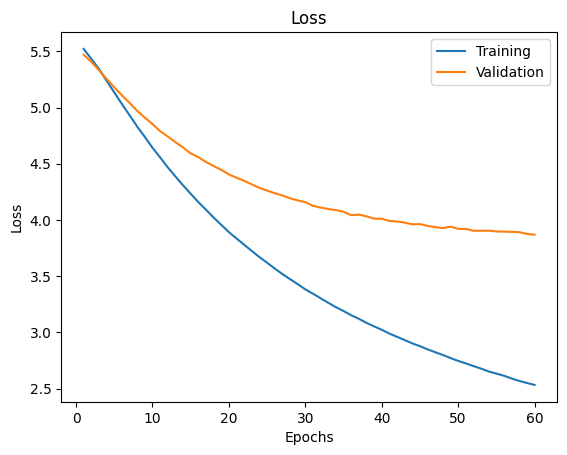

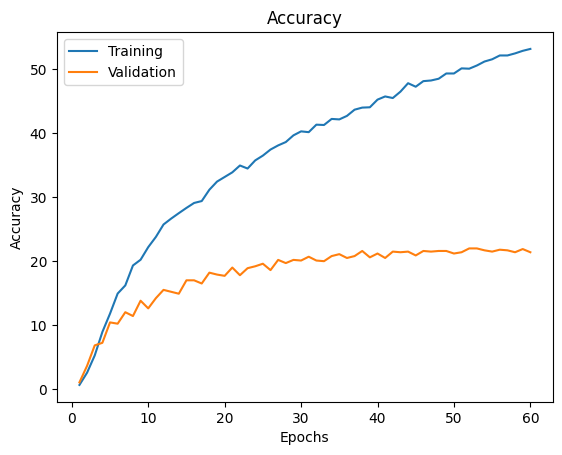

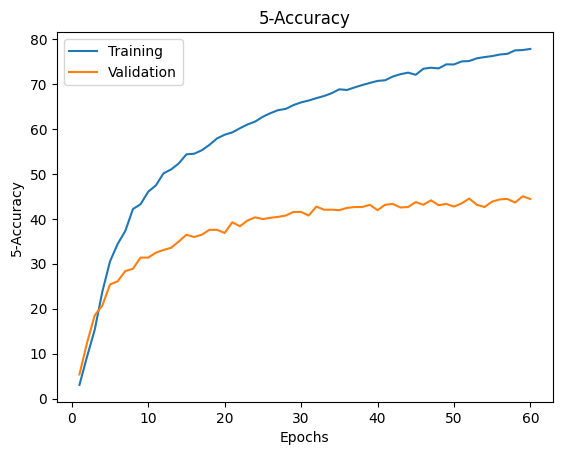

In [16]:

def plot(history, type, model_name):
  x_plot = list(range(1,len(history)+1))
  plt.figure()
  plt.title(type)
  plt.xlabel('Epochs')
  plt.ylabel(type)
  plt.plot(x_plot, history[:,0])
  plt.plot(x_plot, history[:,1])
  plt.legend(['Training', 'Validation'])
  plt.savefig("./Transfer_Learning/models_plots/ResNet50/{}_{}.png".format(type,model_name))

extra = [True, "_food_dataset"]
stratified_kFold = False
# print(losses)
if stratified_kFold:
  for i in range(5):
    model_name = "{}e_{}bsize80_20_split_fold{}".format(n_epochs, batch_size, i+1)
    if extra[0]:
        model_name += extra[1]
    plot(models_losses[i], "Loss", model_name=model_name)
    plot(models_accuracies[i], "Accuracy", model_name=model_name)
    plot(models_k_accuracies[i], f"{k_for_accuracy}-Accuracy", model_name=model_name)
else:
  model_name = "{}e_{}bsize_80_20_split".format(n_epochs, batch_size)
  if extra[0]:
        model_name += extra[1]
  plot(losses, "Loss", model_name=model_name)
  plot(accuracies, "Accuracy", model_name=model_name)
  plot(k_accuracies, f"{k_for_accuracy}-Accuracy", model_name=model_name)

In [8]:
test_loader = DataLoader(dataset_val, batch_size=1, shuffle=False)
cm = eval_model_on_test_loader(model=trained_model, model_name=model_name, target_dir="Transfer_Learning", test_loader=test_loader, cuda=True, k_for_accuracy=5)
np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
print("CM filename: {}".format("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name)))
torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
print("Model saved at: {}".format("./Storage/models/Neural_models/{}.pth".format(model_name)))

NameError: name 'dataset_val' is not defined

In [40]:
trained_model = torch.load("./Storage/models/Neural_models/{}.pth".format("finetunedResNet50_minusnessuno_60e_64bsize_80_20_split_test_dataset"))
linear_layers_to_remove = "nessuno"
extra = [True, "_test_dataset"]
stratified_kFold = False
n_epochs = 60
batch_size = 64
k_for_accuracy = 5
if stratified_kFold:
  for i in range(5):
    print("model of fold: {}".format(i+1))
    model_name = "finetunedResNet50_minus{}_{}e_{}bsize_80_20_split_fold{}".format(linear_layers_to_remove, n_epochs, batch_size, i+1)
    if extra[0]:
        model_name += extra[1]
    cm = eval_model_on_test_set(trained_models[i], model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
else:
  model_name= "finetunedResNet50_minus{}_{}e_{}bsize_80_20_split".format(linear_layers_to_remove, n_epochs, batch_size)
  if extra[0]:
        model_name += extra[1]
  cm = eval_model_on_test_set(trained_model, model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
  np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
  print("CM filename: {}".format("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name)))

100%|██████████| 11994/11994 [00:11<00:00, 1074.64it/s]

Accuracy: 23.77021844255461 %
5-Accuracy: 47.2736368184092
CM filename: ./Transfer_Learning/model_metrics/ConfM_finetunedResNet50_minusnessuno_60e_64bsize_80_20_split_test_dataset.npy


In [37]:
linear_layers_to_remove = "nessuno"
if stratified_kFold:
  for i in range(5):
    print("model of fold: {}".format(i+1))
    model_name = "finetunedResNet50_minus{}_{}e_{}bsize_80_20_split_fold{}".format(linear_layers_to_remove, n_epochs, batch_size, i+1)
    if extra[0]:
        model_name += extra[1]
    cm = eval_model_on_test_set(trained_models[i], model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
else:
  model_name= "finetunedResNet50_minus{}_{}e_{}bsize_80_20_split".format(linear_layers_to_remove, n_epochs, batch_size)
  if extra[0]:
        model_name += extra[1]
  cm = eval_model_on_test_set(trained_model, model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
  np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
  print("CM filename: {}".format("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name)))
  torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
  print("Model saved at: {}".format("./Storage/models/Neural_models/{}.pth".format(model_name)))

100%|██████████| 1004/1004 [00:00<00:00, 1016.20it/s]

Accuracy: 22.808764940239044 %
5-Accuracy: 44.42231075697211
CM filename: ./Transfer_Learning/model_metrics/ConfM_finetunedResNet50_minusnessuno_60e_64bsize_80_20_split_test_dataset.npy
Model saved at: ./Storage/models/Neural_models/finetunedResNet50_minusnessuno_60e_64bsize_80_20_split_test_dataset.pth


In [8]:
uova_pesce, pasta_riso, carne_pollo, torte, dolci, panini_tacos, altro = separate_data_based_on_class_group(X_train_ale_n, y_train)

lista_dati = [[uova_pesce, "uova_pesce"],
              [pasta_riso, "pasta_riso"],
              [carne_pollo, "carne_pollo"],
              [torte, "torte"],
              [dolci, "dolci"],
              [panini_tacos, "panini_tacos"],
              [altro, "altro"]]

uova_pesce, pasta_riso, carne_pollo, torte, dolci, panini_tacos, altro = separate_data_based_on_class_group(X_test_ale_n, y_test)

lista_dati_val = [[uova_pesce, "uova_pesce_val"],
              [pasta_riso, "pasta_riso_val"],
              [carne_pollo, "carne_pollo_val"],
              [torte, "torte_val"],
              [dolci, "dolci_val"],
              [panini_tacos, "panini_tacos_val"],
              [altro, "altro_val"]]

------------------Layers to fine-tune------------------
Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=251, bias=True)
)
-------------------------------------------------------
EPOCH 1:
---------------------Training---------------------
Batch 10 di 10
Training Loss: 5.313326835632324, Accuracy: 2.7027027027027026%, 5-Accuracy: 10.135135135135135%
--------------------------------------------------
--------------------Validation--------------------
Validation Loss: 4.934771378835042, Accuracy: 6.081081081081081%, 5-Accuracy: 22.2972972972973%
EPOCH 2:
---------------------Training---------------------
Batch 10 di 10
Training Loss: 4.612518978118897, Accuracy: 4.222972972972973%, 5-Accuracy: 20.27027027027027%
--------------------------------------------------
--------------------Validation--------------------
Validation Loss: 4.244996229807536, Accuracy: 2.7027027027027026%, 5-Accuracy: 19.5945945945945

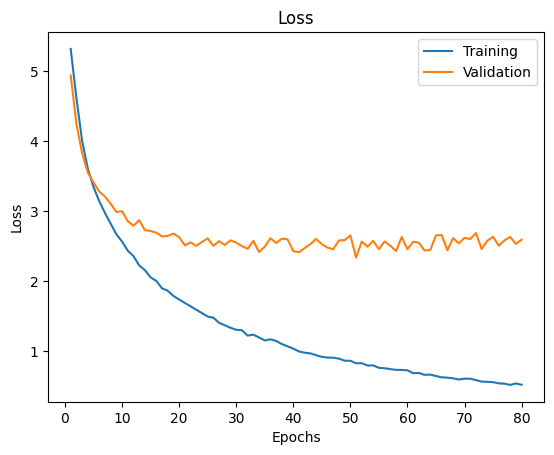

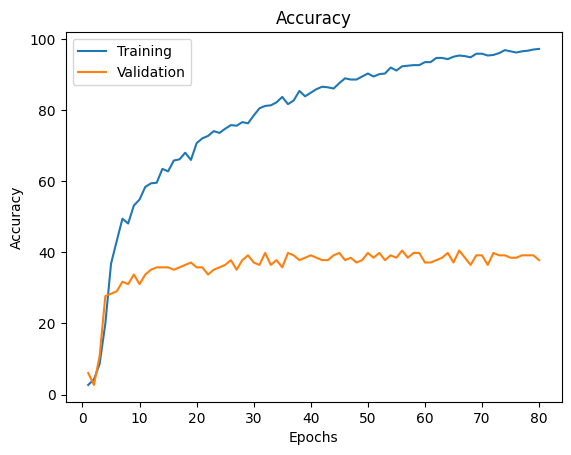

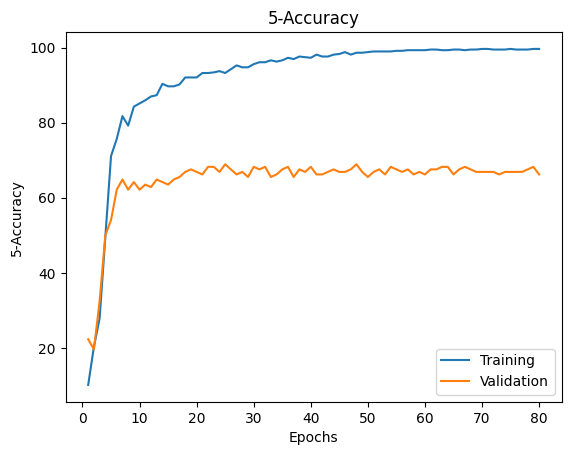

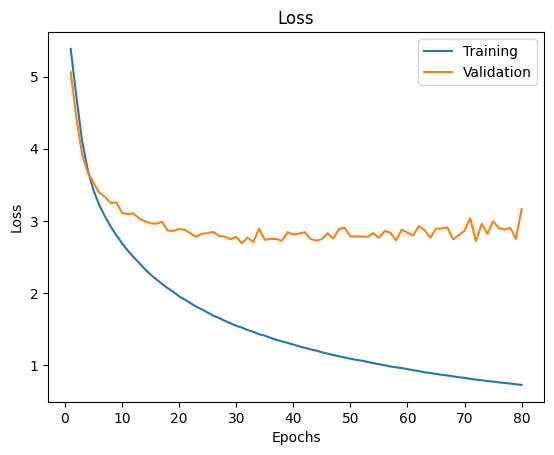

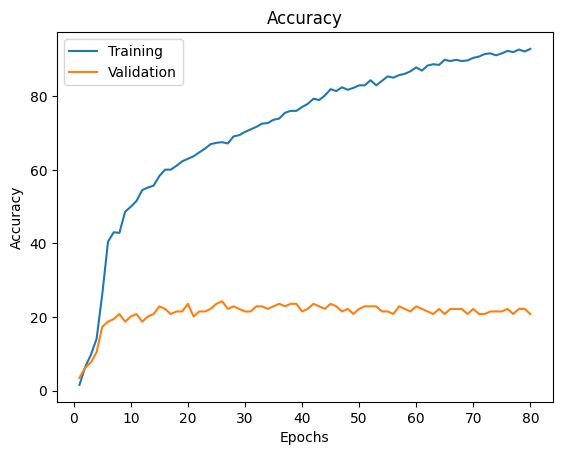

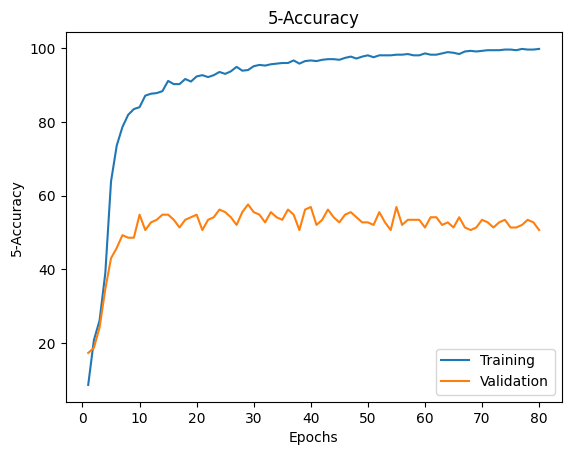

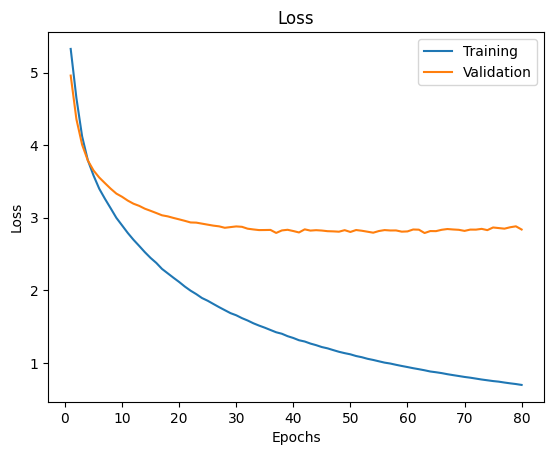

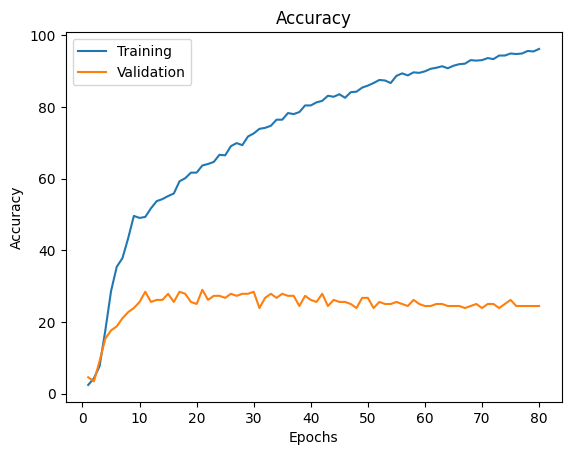

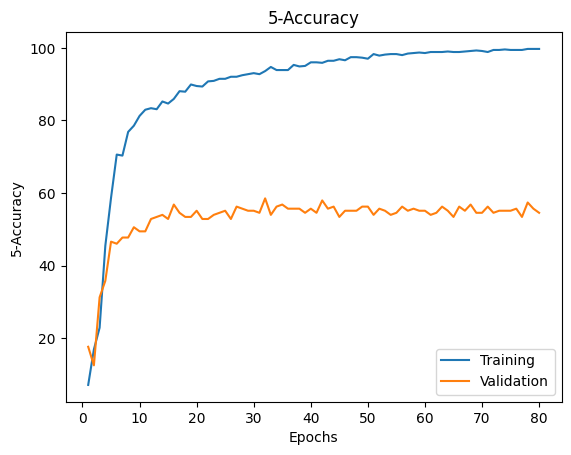

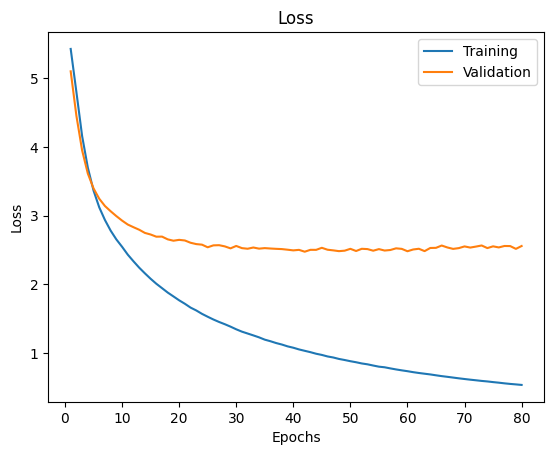

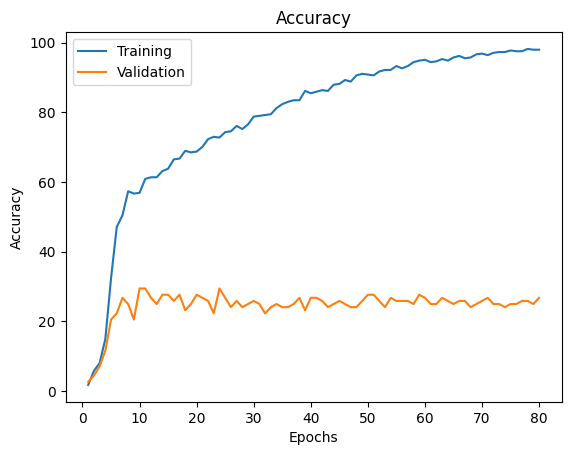

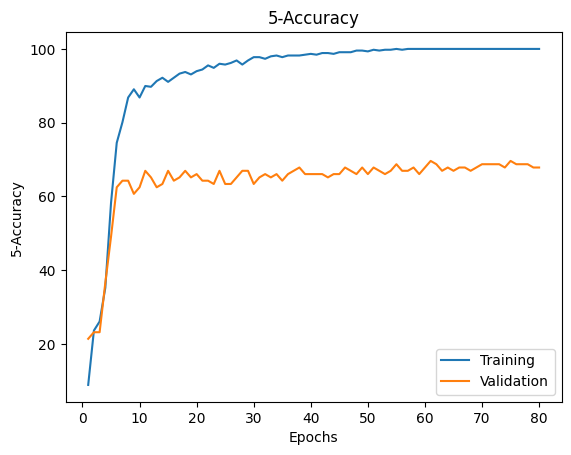

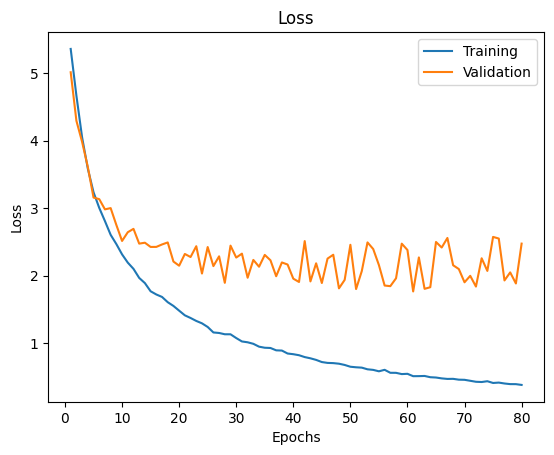

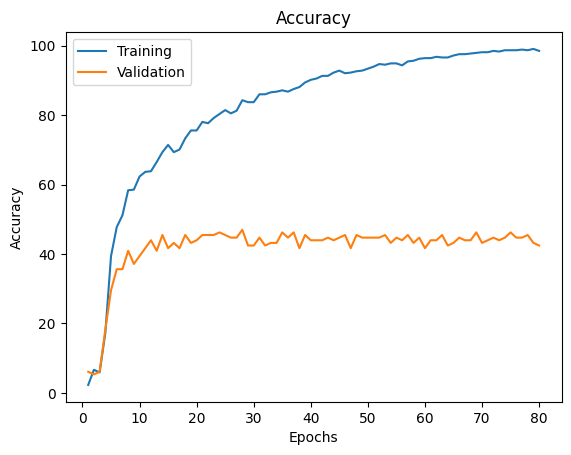

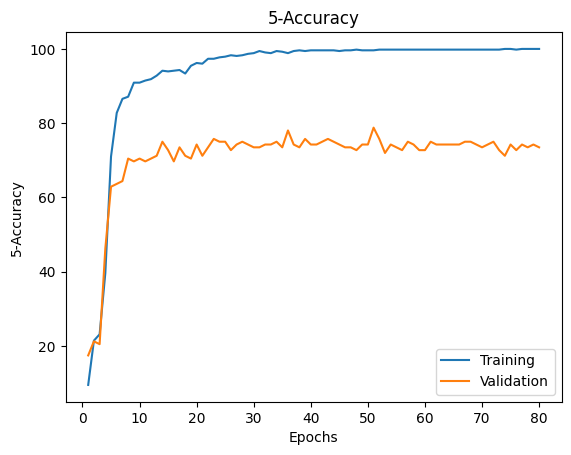

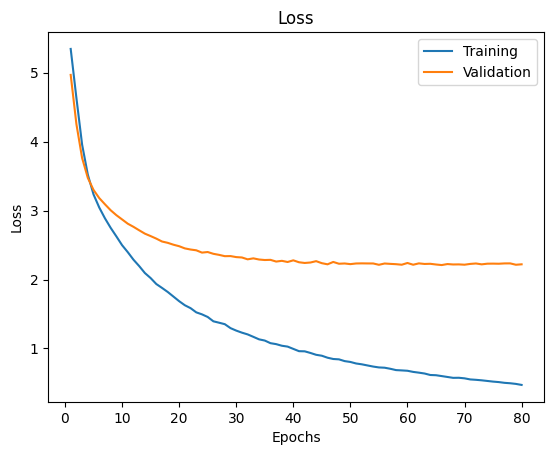

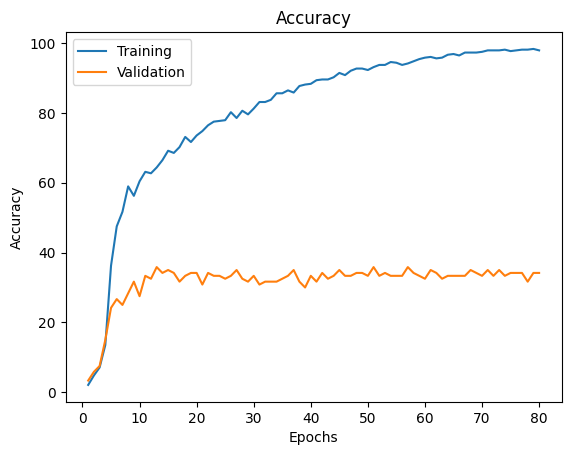

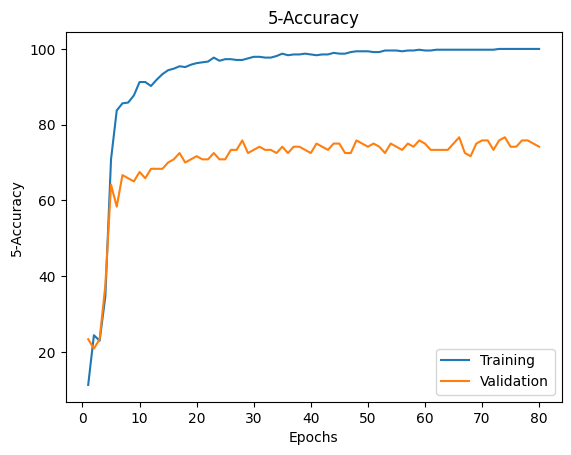

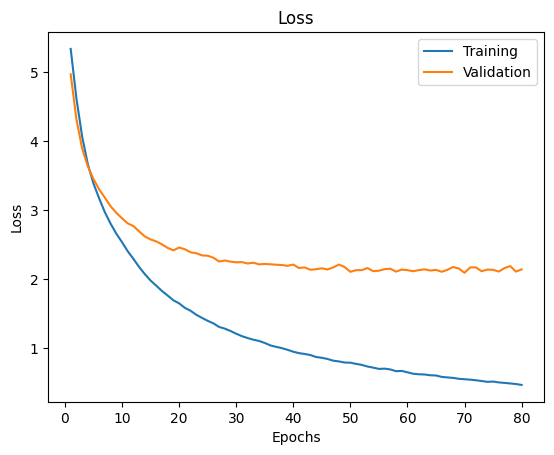

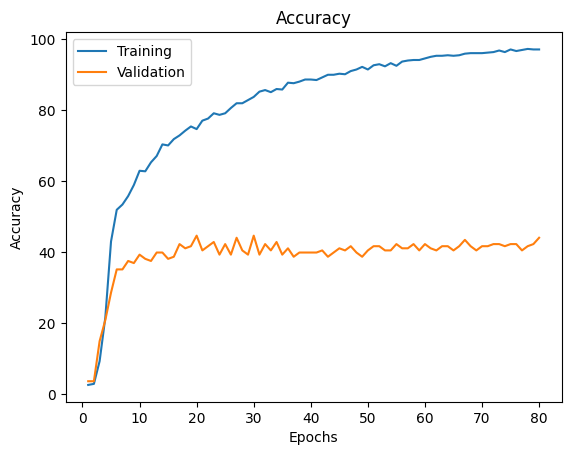

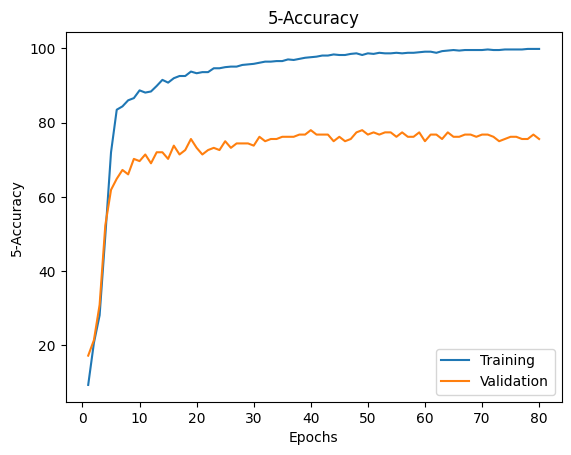

In [9]:
for dato, dato_val in zip(lista_dati, lista_dati_val):
  loss_function = torch.nn.CrossEntropyLoss()

  model = deepcopy(fine_tune_layers)

  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  stratified_kFold = False
  n_epochs = 80
  batch_size = 64
  k_for_accuracy = 5

  x = torch.from_numpy(dato[0][0]).cuda()
  y = torch.from_numpy(dato[0][1]).cuda()
  x_val = torch.from_numpy(dato_val[0][0]).cuda()
  y_val = torch.from_numpy(dato_val[0][1]).cuda()

  trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda, model=model, x_train=x, y_train=y, x_val = x_val, y_val = y_val, n_epochs=n_epochs,
                                                  batch_size=batch_size, loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)


  def plot(history, type, model_name):
    x_plot = list(range(1,len(history)+1))
    plt.figure()
    plt.title(type)
    plt.xlabel('Epochs')
    plt.ylabel(type)
    plt.plot(x_plot, history[:,0])
    plt.plot(x_plot, history[:,1])
    plt.legend(['Training', 'Validation'])
    plt.savefig("./Transfer_Learning/models_plots/GoogLeNet/{}_{}.png".format(type,model_name))

  # print(losses)
  model_name = "{}_".format(dato[1])
  if stratified_kFold:
    for i in range(5):
      model_name += "{}e_80_20_split_fold{}".format(n_epochs, i+1)
      plot(models_losses[i], "Loss", model_name=model_name)
      plot(models_accuracies[i], "Accuracy", model_name=model_name)
      plot(models_k_accuracies[i], f"{k_for_accuracy}-Accuracy", model_name=model_name)
  else:
    model_name += "{}e_80_20_split".format(n_epochs)
    plot(losses, "Loss", model_name=model_name)
    plot(accuracies, "Accuracy", model_name=model_name)
    plot(k_accuracies, f"{k_for_accuracy}-Accuracy", model_name=model_name)

  torch.save(trained_model, "./Storage/models/Neural_models/{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format(dato[1],linear_layers_to_remove, n_epochs))
  print("Saved model at: {}".format("./Storage/models/Neural_models/{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format(dato[1],linear_layers_to_remove, n_epochs)))

In [10]:
from utils.fine_tune_pytorch import eval_ensamble_on_test_set
n_epochs = 80
batch_size = 64
k_for_accuracy = 5
linear_layers_to_remove = 1

In [11]:
general_model_name = "./Storage/models/Neural_models/"
pasta_riso = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("pasta_riso",linear_layers_to_remove, n_epochs)
uova_pesce = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("uova_pesce",linear_layers_to_remove, n_epochs)
carne_pollo = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("carne_pollo",linear_layers_to_remove, n_epochs)
torte = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("torte",linear_layers_to_remove, n_epochs)
dolci = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("dolci",linear_layers_to_remove, n_epochs)
panini_tacos = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("panini_tacos",linear_layers_to_remove, n_epochs)
altro = general_model_name + "{}_finetunedGoogLeNet_minus{}_{}e_80_20_split.pth".format("altro",linear_layers_to_remove, n_epochs)

pasta_riso_model = torch.load(pasta_riso)
uova_pesce_model = torch.load(uova_pesce)
carne_pollo_model = torch.load(carne_pollo)
torte_model = torch.load(torte)
dolci_model = torch.load(dolci)
panini_tacos_model = torch.load(panini_tacos)
altro_model = torch.load(altro)

ensamble_model = [pasta_riso_model,
                  uova_pesce_model,
                  carne_pollo_model,
                  torte_model,
                  dolci_model,
                  panini_tacos_model,
                  altro_model]

cm = eval_ensamble_on_test_set(ensamble_model, "prova", "Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy=k_for_accuracy)

100%|██████████| 1004/1004 [00:03<00:00, 312.53it/s]

Accuracy: 14.54183266932271 %


In [7]:
chosen_net = networks.RESNET50
# print("Original classification layers:{}".format(chosen_net.value[1]))
print(list(chosen_net.value[1].children())[4])
print(len(list(chosen_net.value[1].children())))

Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Bottleneck(
    (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, ke

In [ ]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu

linear_layers_to_remove = 3
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers, modified_net = extract_features(train_set=datasets.TRAINING_80,
                                                                                            test_set=datasets.VALIDATION_20,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda, middle=True)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

In [8]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./Storage/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc

In [ ]:
array = []
for i in range(0,len(X_train_ale_n)):
    array.append(np.matrix.flatten(X_train_ale_n[i]))
array = np.array(array)
print(array.shape)
X_train_ale_n= array

array = []
for i in range(0,len(X_test_ale_n)):
    array.append(np.matrix.flatten(X_test_ale_n[i]))
array = np.array(array)
print(array.shape)
X_test_ale_n = array


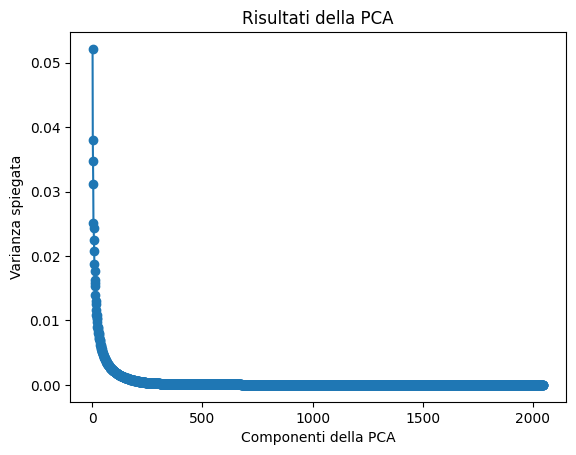

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

is_pca_used = True

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train_ale_n)
pca = PCA().fit(scaled_data)

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()


In [ ]:
components = 500
pca = PCA(n_components=components).fit(scaled_data)
X_train_pca = pca.transform(scaled_data)
print("Final input shape train: {}".format(X_train_pca.shape))

scaled_data = scaler.fit_transform(X_test_ale_n)
x_test_pca = pca.transform(scaled_data)
print("Final input shape test: {}".format(x_test_pca.shape))

Final input shape train: (4016, 500)
Final input shape test: (1004, 500)


 14%|█▍        | 1/7 [32:25<3:14:35, 1945.97s/it]

Linear Support Vector obtained following accuracy: 0.11752988047808766


 29%|██▊       | 2/7 [33:19<1:09:24, 832.85s/it] 

Rbf Support Vector obtained following accuracy: 0.1942231075697211


 43%|████▎     | 3/7 [34:08<31:39, 474.94s/it]  

KNN with 1 neighbors obtained following accuracy: 0.11055776892430279


 57%|█████▋    | 4/7 [34:55<15:17, 305.99s/it]

KNN with 10 neighbors obtained following accuracy: 0.10258964143426295


 71%|███████▏  | 5/7 [35:43<07:05, 212.74s/it]

KNN with 20 neighbors obtained following accuracy: 0.12250996015936255


 86%|████████▌ | 6/7 [36:31<02:36, 156.96s/it]

KNN with 50 neighbors obtained following accuracy: 0.12350597609561753


100%|██████████| 7/7 [37:22<00:00, 320.36s/it]

Naive Bayes obtained following accuracy: 0.1344621513944223


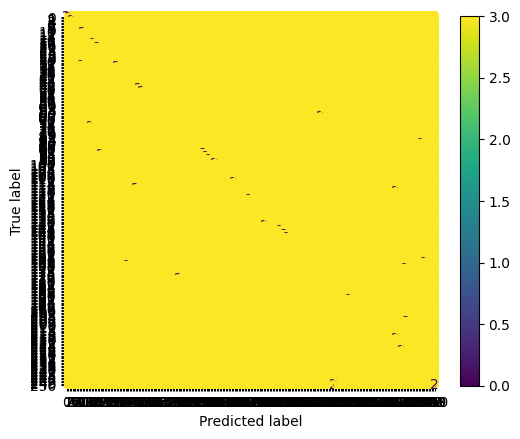

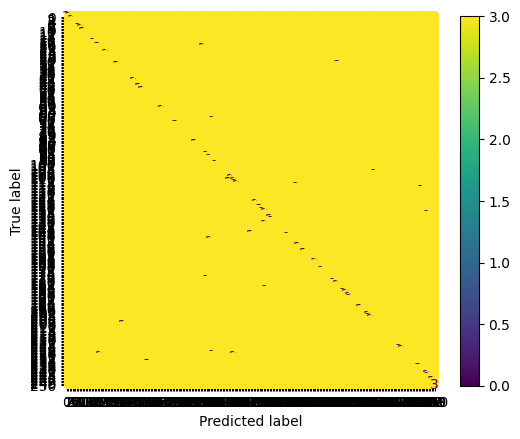

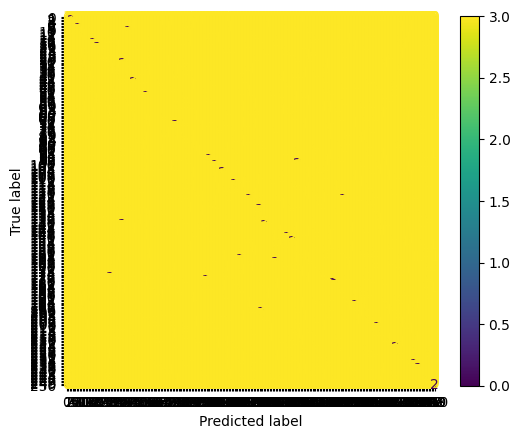

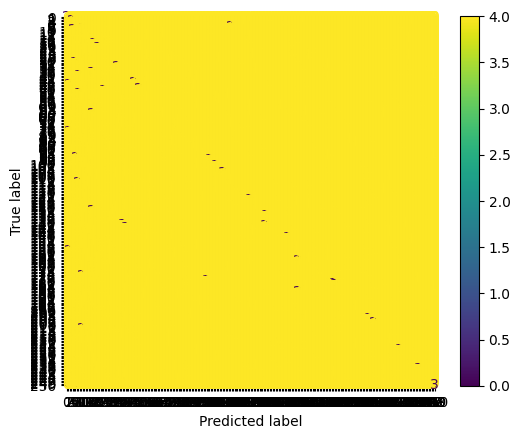

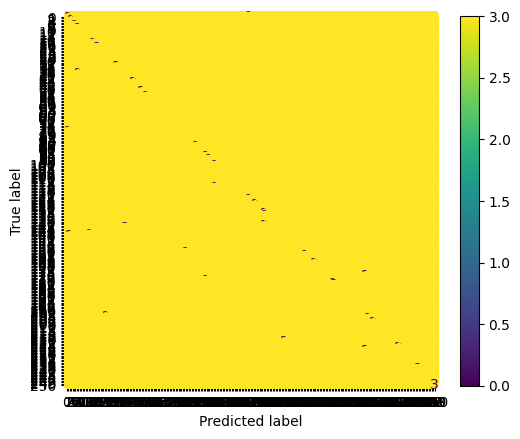

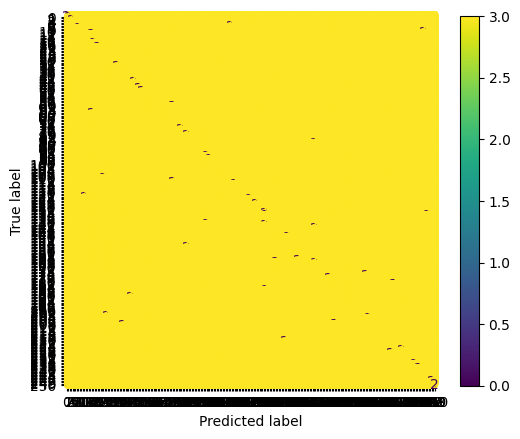

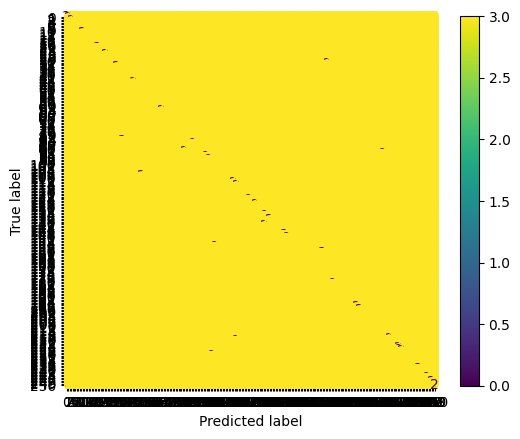

In [11]:

from enum import Enum
class ml_models(Enum):
    LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RBF_SVC = [SVC(kernel="rbf"), "Rbf Support Vector"]
    # RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]

is_pca_used = True
extra = [False, "_mixed_dataset"]

x_train = X_train_ale_n
x_test = X_test_ale_n
if is_pca_used:
    x_train = X_train_pca
    x_test =x_test_pca
model_accuracies = []
for model in tqdm(ml_models):    
    model_name = "{}_from_{}_until{}".format(model.value[1], chosen_net.value[2], linear_layers_to_remove)
    if is_pca_used:
        model_name += "_pca"
    if extra[0]:
        model_name += extra[1]
    score = model_building(model.value[0], model_name, x_train, x_test, y_train, y_test)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
accuracies_filename = "./Transfer_Learning/model_metrics/Accuracies_{}_until{}".format(chosen_net.value[2], linear_layers_to_remove)
if is_pca_used:
    accuracies_filename += "_pca"
if extra[0]:
        model_name += extra[1]

np.save("{}.npy".format(accuracies_filename), model_accuracies)